<a href="https://colab.research.google.com/github/CurtisChris7/Berkley-Pacman-Solutions/blob/main/toloka_faces_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annotating ground truth for object detection

The goal of this notebook is to annotate images which can later be used for training object detection algorithms.

We will configure and run the annotation project in Toloka from scratch.

Follow the steps in this notebook to get the labeled data at the end.


## Prerequisites
To proceed with this notebook:
- Make sure you are [registered](https://toloka.ai/get-started/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) in Toloka as a requester.
- Use the promo code **HCOMP22** to add $30 to your account on your [profile page](https://platform.toloka.ai/requester/profile/income/?utm_source=github&utm_medium=site&utm_campaign=tolokakit). You can use it to pay for data labeling while following this tutorial.

![picture](https://docs.google.com/uc?id=109JZwLCtOLp55TPLIyB5nfAJxJS05tyc)


## The challenge
We have a set of photos with people in them:

<table  align="center">
  <tr><td>
    <img src="https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/images/5fc9583cbda646c7de9c6451b7f22a165b6b7d4b.jpg"
         alt="Sample photo of people"  width="650">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> Sample photo of people
  </td></tr>
</table>

We need to outline every person's face. Ultimately, we need to get a set of pixelwise boundaries that represent the people's faces in each photo. Here’s what it can look like:

<table  align="center">
  <tr><td>
    <img src="https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/segmentation_example.png"
         alt="Example of how people face detection can be performed"  width="650">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> An example of how face detection can be performed
  </td></tr>
</table>

This type of annotation often uses polygons. We are using bounding boxes to simplify the task so that we can reduce costs and speed things up.  You can still use polygons, just uncomment the related pieces of code.

### Detailed task description
In this notebook, we will implement projects #2 and #3 from [this Toloka tutorial](https://toloka.ai/docs/guide/concepts/image-segmentation-overview.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit). Feel free to check them out if you want to learn how to configure these projects in the web interface. Otherwise you can skip it, since this notebook covers all the steps using the Toloka API.

We’ll skip the first project “Does the image contain a specific object?” from the tutorial above because it’s easy to implement using our “verification project” code.

We will implement two projects in Toloka:
- A detection project called “[Select an object in the image](https://toloka.ai/docs/guide/concepts/image-segmentation-project2.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit)”: Tolokers will select image areas that contain faces. Tolokers are people around the world who get paid for completing your tasks. 
- A verification project called “[Are the bounding boxes correct?](https://toloka.ai/docs/guide/concepts/image-segmentation-project3.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit)”: Tolokers will check the annotated images.

We don’t use [control tasks](https://toloka.ai/docs/guide/concepts/goldenset.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) or [majority vote](https://toloka.ai/docs/guide/concepts/mvote.html?utm_source=github&utm_medium=site&utm_campaign=tolokakit) to control quality in the detection project because we can’t expect the image annotations provided by the Tolokers to match each other exactly to the pixel. Instead, we’ll check detection results in the second project, where a different group of Tolokers will decide whether the faces are annotated correctly or not.

### Set up the environment

Prepare the environment and import necessary libraries.

In [ ]:
!pip install toloka-kit==1.0.2 # To interact with Toloka API
!pip install ipyplot # To plot images inside Jupyter Notebooks cells
!pip install crowd-kit==1.1.0
!pip install nest_asyncio

import os
import datetime
import time
import logging
import sys
import getpass

import pandas as pd   # To perform data manipulation
import ipyplot


from typing import List
from toloka.streaming.event import AssignmentEvent

import toloka.client as toloka
import toloka.client.project.template_builder as tb

from crowdkit.aggregation import MajorityVote

logging.basicConfig(
    format='[%(levelname)s] %(name)s: %(message)s',
    level=logging.INFO,
    stream=sys.stdout,
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create a toloka-client instance. All API calls will pass through it.

To get an OAuth token, follow these [instructions](https://toloka.ai/en/docs/api/concepts/access/?utm_source=github&utm_medium=site&utm_campaign=tolokakit). Enter your token.

In [ ]:
toloka_client = toloka.TolokaClient(getpass.getpass("Enter your token:"), 'PRODUCTION')
print(toloka_client.get_requester())

Enter your token:··········
Requester(_unexpected={}, id='b39ea2ce2474c437ed0ee0d4aeec630b', balance=Decimal('3128.1974'), public_name={'EN': 'Ya.Apollyon', 'FR': 'Ya.Apollyon', 'ID': 'Ya.Apollyon', 'RU': 'Я.Аполлион', 'TR': 'Ya.Apollyon'}, company=Requester.Company(_unexpected={}, id='1', superintendent_id='56caaaeeea84b3b3765420ef45a08262'))


Check out Toloka documentation to learn more about [the Toloka API](https://toloka.ai/en/docs/api/?utm_source=github&utm_medium=instruction-a&utm_campaign=link-9) and [Toloka-Kit](https://toloka.ai/en/docs/toloka-kit/?utm_source=github&utm_medium=instruction-a&utm_campaign=link-10).

### Download all neccessary data
We use the [Human Parts Dataset](https://github.com/xiaojie1017/Human-Parts/?utm_source=github&utm_medium=instruction-a&utm_campaign=link-11), distributed under the MIT license.

Our dataset is just a collection of URLs leading to JPEG images. GIF, PNG, and WEBP formats are also supported.

In [ ]:
!curl https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/dataset.tsv --output dataset.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36306  100 36306    0     0  58369      0 --:--:-- --:--:-- --:--:-- 58369


We also need to download configuration files for projects and pools

In [ ]:
!mkdir configs

!curl https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/detection_project_config.json --output configs/detection_project_config.json

!curl https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/detection_pool_config.json --output configs/detection_pool_config.json

!curl https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/verification_project_config.json --output configs/verification_project_config.json

!curl https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/verification_pool_config.json --output configs/verification_pool_config.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4742  100  4742    0     0  10175      0 --:--:-- --:--:-- --:--:-- 10175
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5077  100  5077    0     0  11013      0 --:--:-- --:--:-- --:--:-- 10989
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7407  100  7407    0     0  16102      0 --:--:-- --:--:-- --:--:-- 16102
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3513  100  3513    0     0   7703      0 --:--:-- --:--:-- --:--:--  7687


### Review the dataset

In [ ]:
# Load the dataset of links to a pd DataFrame
dataset = pd.read_csv('dataset.tsv', sep='\t')

# Plot 5 images from dataset to verify data loading
ipyplot.plot_images(
    [url for url in dataset['image'].sample(n=50)],
    max_images=5,
    img_width=1000
)

---
---
## Create a new detection project from config file

In this project, Tolokers select image areas that contain faces.

The first step is to configure how Tolokers will see the tasks:
- Write instructions.
- Define the input and output formats.

**Note:** It’s important to write clear instructions with examples to make sure the Tolokers do exactly what we need them to. We also recommend checking the task interface yourself to see if there are any problems with the layout.   

We **highly recommend** requesters to create a project in [Toloka Requester Portal](https://platform.toloka.ai/requester/).

As the project was already created, we will use configuration file to recreate the detection project

In [ ]:
with open('configs/detection_project_config.json') as project_config_file:
    json_string = project_config_file.read()
detection_project = toloka.Project.from_json(json_string)
detection_project = toloka_client.create_project(detection_project)

### Review your project and check the task interface

Visit the project page to make sure the task interface is working correctly.

To do this:
1. Follow the link you got in the output above.
2. In the project interface, click **Project actions** on the top right.
3. Click **Preview** in the menu.
4. Click **Change input data**.
5. Insert an image URL into the **Image** field. Here, you can use a link to one of the images you want to label, or [this sample image](https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/images/5fc9583cbda646c7de9c6451b7f22a165b6b7d4b.jpg).
6. Click the **Instructions** button. Make sure the instructions are visible and valid.
7. Try to select multiple areas with a rectangle using **Box annotation tool**.
8. Click **Submit** and then click **View responses**.

A window with the results will appear. Check that the results are in the expected format and that the data is being entered correctly.


<table  align="center">
  <tr><td>
    <img src="https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/segmentation_results_preview.png"
         alt="Task interface"  width="800">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> What the results window might look like
  </td></tr>
</table>

**Tip:** Do a trial run with a small sample of your data. Make sure that after running a trial for the entire pipeline, you get data with the expected format and quality. 

### Add custom skills for tolokers

A [skill](https://toloka.ai/docs/guide/concepts/nav.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) is a characteristic of a Toloker. For example, you can record the percentage of correct responses as a skill.

In this project, we’ll create two skills:
- **Detection skill**: Shows that a Toloker has completed at least one detection task. We’ll later filter out these Tolokers from verification tasks to ensure that the people doing the verification are not the same people who performed the detection.
- **Verification skill**: How good the current Toloker’s verification results are compared to others. We’ll need this skill later when we aggregate the results of the second project. 

In [ ]:
detection_skill = next(toloka_client.get_skills(name='Area selection of people faces'), None)
if detection_skill:
    print('Detection skill already exists')
else:
    detection_skill = toloka_client.create_skill(
        name='Area selection of people faces',
        hidden=True,
        public_requester_description={'EN': 'Toloker is annotating people faces'},
    )

verification_skill = next(toloka_client.get_skills(name='People faces detection verification'), None)
if verification_skill:
    print('Verification skill already exists')
else:
    verification_skill = toloka_client.create_skill(
        name='People faces detection verification',
        hidden=True,
        public_requester_description={'EN': 'How good a toloker is at verifying detection tasks'},
    )

Detection skill already exists
Verification skill already exists


### Pool creation for a detection project
A [pool](https://toloka.ai/docs/guide/concepts/pool-main.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) is a set of tasks sent out for Tolokers. 
Pool also contain criteria to filter out Tolokers and quality control rules. 

We also recommend creating pools in [Toloka Requester Portal](https://platform.toloka.ai/requester/).

As the pool was already created, we will use configuration file to recreate the detection pool

In [ ]:
with open('configs/detection_pool_config.json') as pool_config_file:
    json_string = pool_config_file.read()
    json_string = json_string.replace('DETECTION_SKILL_ID', detection_skill.id)

detection_pool = toloka.Pool.from_json(json_string)

detection_pool.project_id = detection_project.id
detection_pool.will_expire = datetime.datetime.utcnow() + datetime.timedelta(days=7)

detection_pool = toloka_client.create_pool(detection_pool)

---
---
## Create a new project for verification
In this project, Tolokers will determine whether the faces were outlined correctly or not.

This will be a standard classification project with only two classes: `OK` and `BAD`. We’ll explicitly define these labels as the output values.       


In [ ]:
with open('configs/verification_project_config.json') as project_config_file:
    json_string = project_config_file.read()
verification_project = toloka.Project.from_json(json_string)
verification_project = toloka_client.create_project(verification_project)

Examine the project in the web interface:

1. After running the code above, you’ll get a link to your project. Follow this link to check the task interface and instructions.

    **Note:** You will see almost the same interface as in the previous project, just without the ability to select areas. It’s important to make sure that the annotation results from the first project are displayed correctly in the second one.
    
    
2. Open the task **Preview** in the first project.


3. Outline the faces and click **Submit**.


4. Copy the results.


5. Now open the **Preview** of the second project.


6. Click **Change input data** and paste the annotation results in the selection field.


7. Click **Apply** and make sure the annotation displays correctly. 

### Create and set up a pool in the verification project

As the pool was already created, we will use configuration file to recreate the verification pool

In [ ]:
with open('configs/verification_pool_config.json') as pool_config_file:
    json_string = pool_config_file.read()
    json_string = json_string.replace('DETECTION_SKILL_ID', detection_skill.id)
    json_string = json_string.replace('VERIFICATION_SKILL_ID', verification_skill.id)

verification_pool = toloka.Pool.from_json(json_string)

verification_pool.project_id = verification_project.id
verification_pool.will_expire = datetime.datetime.utcnow() + datetime.timedelta(days=7)

verification_pool = toloka_client.create_pool(verification_pool)

---
---
## Add tasks to pools and run the projects
At this point, we have configured two projects, and now we can upload the real data that we want to annotate.

In [ ]:
tasks = [
    toloka.Task(input_values={'image': url}, pool_id=detection_pool.id)
    for url in dataset['image'].values[:5]
]
# Add tasks to a pool
toloka_client.create_tasks(tasks, allow_defaults=True,)

detection_pool = toloka_client.open_pool(detection_pool.id)

100%|██████████| 100/100 [00:01<00:00, 50.98it/s]


Visit the pool page in the web interface and make sure the number of tasks is correct and the pool is running. Some tasks may already be completed.

<table  align="center">
  <tr><td>
    <img src="https://tolokacommunity.blob.core.windows.net/toloka-faces-detection/segmentation_pool_look.png"
         alt="Pool with tasks"  width="800">
  </td></tr>
  <tr><td align="center">
    <b>Figure 4.</b> What a running pool might look like
  </td></tr>
</table>


Tolokers work really fast, but they still need time to complete their tasks. We’ll use streaming to start the verification project without having to wait until the detection pool closes completely.

Next, [review](https://toloka.ai/docs/guide/concepts/offline-accept.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) the detection results in the web interface.

In [ ]:
from toloka.streaming import AssignmentsObserver, Pipeline
from toloka.streaming.storage import JSONLocalStorage

In [ ]:
# class for handling submissions in the detection pool
class DetectionSubmittedHandler:
    def __init__(self, client, verification_pool_id):
        self.client = client
        self.verification_pool_id = verification_pool_id

    # create new tasks for the verification pool
    def __call__(self, events: List[AssignmentEvent]) -> None:
        verification_tasks = [
            toloka.Task(
                pool_id=self.verification_pool_id,
                input_values={
                        'image': event.assignment.tasks[0].input_values['image'],
                        'selection': event.assignment.solutions[0].output_values['result'],
                        'assignment_id': event.assignment.id,
                }
            )
            for event in events
        ]
        self.client.create_tasks(verification_tasks, allow_defaults=True, open_pool=True)

In [ ]:
# class for handling accepted tasks in the verification pool
class VerificationDoneHandler:
    def __init__(self, client, verification_skill_id):
        self.microtasks = pd.DataFrame([], columns=['task', 'label', 'worker'])
        self.client = client
        self.verification_skill_id = verification_skill_id

    # filter out tasks that already have enough overlap and aggregate the result
    def __call__(self, events: List[AssignmentEvent]) -> None:
        # Initializing data
        microtasks = pd.concat([self.microtasks, self.as_frame(events)])
        # get user skills for aggregation
        skills = pd.Series({
            skill.user_id: skill.value
            for skill in self.client.get_user_skills(skill_id=self.verification_skill_id)
        })

        # Filtering all microtasks that have overlap of 5
        microtasks['overlap'] = microtasks.groupby('task')['task'].transform('count')
        to_aggregate = microtasks[microtasks['overlap'] >= 5]
        microtasks = microtasks[microtasks['overlap'] < 5]
        aggregated = MajorityVote(on_missing_skill='value', default_skill=0).fit_predict(to_aggregate, skills)
        # Accepting or rejecting assignments
        for assignment_id, result in aggregated.items():
            if result == 'OK':
                self.client.accept_assignment(assignment_id, 'Well done!')
            else:
                toloka_client.reject_assignment(assignment_id, 'The object wasn\'t selected or was selected incorrectly.')

        # Updating mictotasks
        self.microtasks = microtasks[['task', 'label', 'worker']]

    # get the data necessary for aggregation
    @staticmethod
    def as_frame(events: List[AssignmentEvent]) -> pd.DataFrame:
        microtasks = [
            (task.input_values['assignment_id'], solution.output_values['result'], event.assignment.user_id)
            for event in events
            for task, solution in zip(event.assignment.tasks, event.assignment.solutions)
        ]
        return pd.DataFrame(microtasks, columns=['task', 'label', 'worker'])

We’ll create a pipeline with an observer for each pool.

Depending on the number of images in the detection pool and the time of day, the whole process can take from a few minutes to almost an hour. 

In [ ]:
detection_observer = AssignmentsObserver(toloka_client, detection_pool.id)
detection_observer.on_submitted(DetectionSubmittedHandler(toloka_client, verification_pool.id))
verification_observer = AssignmentsObserver(toloka_client, verification_pool.id)
verification_observer.on_accepted(VerificationDoneHandler(toloka_client, verification_skill.id))

# Create a local directory that will store pipeline progress and logs.
# It allows to restart the pipeline without losing data in case of pause or failure.
storage_path = './storage/'
if not os.path.exists(storage_path):
    os.makedirs(storage_path)
storage = JSONLocalStorage(storage_path)

pipeline = Pipeline(storage=storage)
pipeline.register(detection_observer)
pipeline.register(verification_observer)

# Google Colab is using a global event pool,
# so in order to run our pipeline we have to apply nest_asyncio to create an inner pool
if 'google.colab' in str(get_ipython()):
    import nest_asyncio, asyncio
    nest_asyncio.apply()
    asyncio.get_event_loop().run_until_complete(pipeline.run())
else:
    await pipeline.run()

100%|██████████| 100/100 [00:01<00:00, 52.44it/s]


---
---
## Get the results
Now you can download all the accepted tasks from the detection pool and work with them. In this notebook, we’ll only show the detection results. The code below will display the results of the bounding boxes markup.

You can also [download](https://toloka.ai/docs/guide/concepts/result-of-eval.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) results as a TSV file from the web interface.  

In [ ]:
!pip install pillow # To deal with images
!pip install requests # To make HTTP requests
from PIL import Image, ImageDraw
import requests

def get_image(url, selection):
    raw_image = requests.get(url, stream=True).raw
    image = Image.open(raw_image).convert("RGBA")
    regions = Image.new('RGBA', image.size, (255,255,255,0))
    pencil = ImageDraw.Draw(regions)
    for region in selection:
        if region['shape'] != 'rectangle':
            continue
        p1_x = region['left'] * image.size[0]
        p1_y = region['top'] * image.size[1]
        p2_x = (region['left'] + region['width']) * image.size[0]
        p2_y = (region['top'] + region['height']) * image.size[1]
        pencil.rectangle((p1_x, p1_y, p2_x, p2_y), fill =(255, 30, 30, int(255*0.5)))
    image = Image.alpha_composite(image, regions)
    return image

detection_result = {}  # We'll store our result here

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



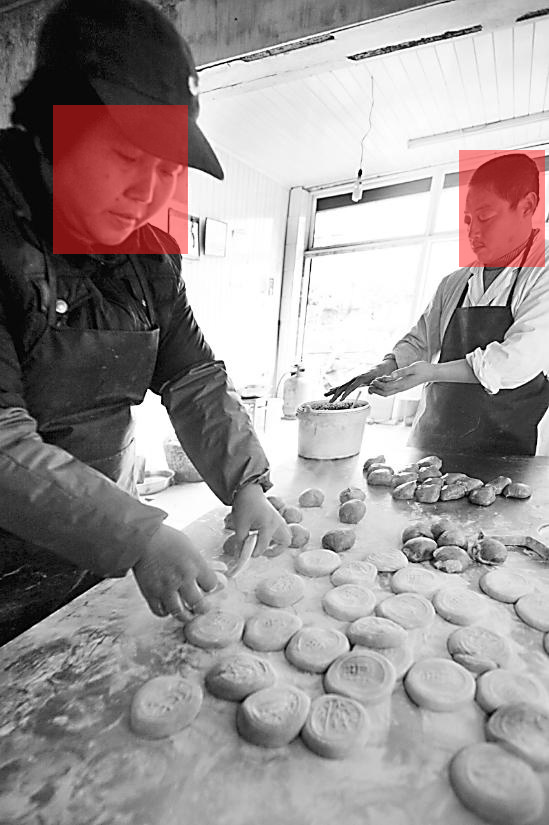
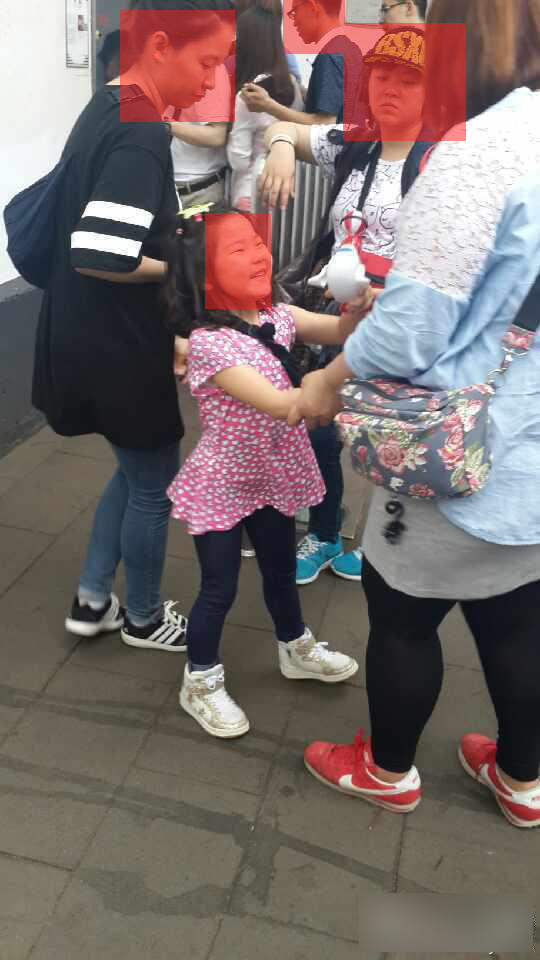


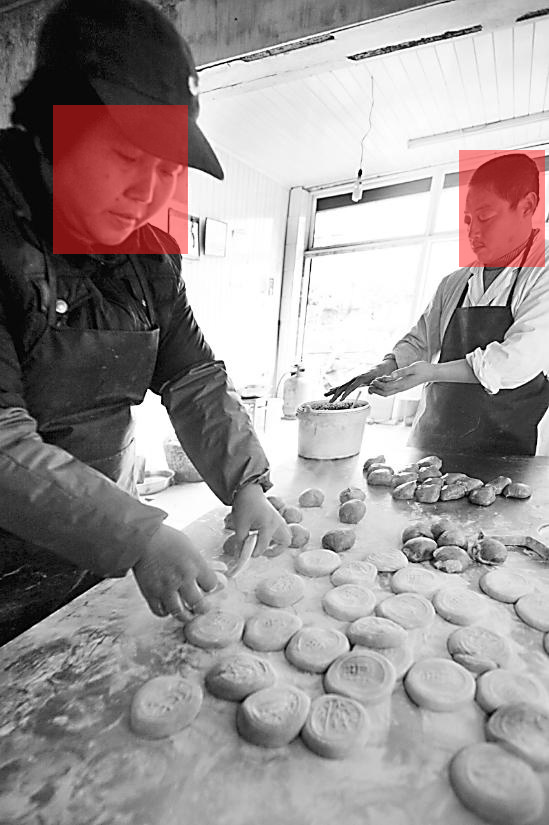
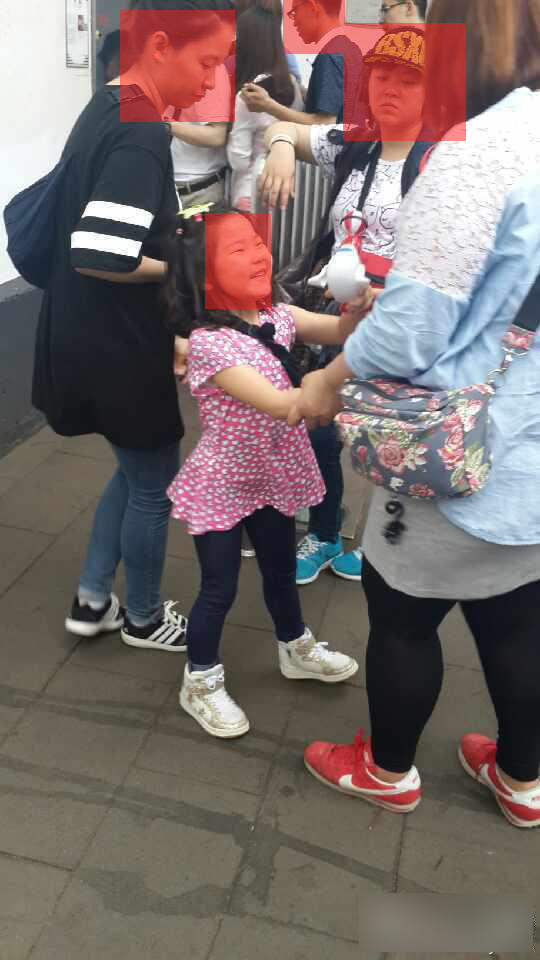

In [ ]:
max_images = 2
images = []

if not detection_result:

    for assignment in toloka_client.get_assignments(
        status='ACCEPTED',
        pool_id=detection_pool.id
    ):
        detection_result[assignment.tasks[0].input_values['image']] = assignment.solutions[0].output_values['result']

for i in range(max_images):
    url, selection = detection_result.popitem()
    image = get_image(url, selection)
    images.append(image)

ipyplot.plot_images(
    images,
    max_images=max_images,
    img_width=1000
)

---
---
## Summary

This project consists of the minimum number of settings that This project has the minimum number of settings that will allow you to collect annotated images for your dataset right from Jupyter Notebook.

For further experiments use the [Toloka-Kit documentation](https://toloka.ai/docs/toloka-kit/index.html/?utm_source=github&utm_medium=site&utm_campaign=tolokakit) and check out other [use cases](https://github.com/Toloka/toloka-kit/tree/main/examples/?utm_source=github&utm_medium=site&utm_campaign=tolokakit).  
